# Phishing Classification

In [40]:
# Retina quality plots
%config InlineBackend.figure_format = 'retina'

## Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
DATA_DIR = '/content/drive/MyDrive/ML-Phishing-Data/'

In [3]:
import pandas as pd

train_data = pd.read_csv(DATA_DIR + 'train.csv')

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53188 entries, 0 to 53187
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 45.4 MB


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,8,1,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,90,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,35,0,0,...,0,0,0,19,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.294114,0,35994,-1,-1,1,4,0,11,1,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.217541,0,16347,6043,1992,1,1,1,21592,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,18,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,0,0,...,0,0,0,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.435229,0,-1,10672,283,4,4,2,194,1,1,0,0,0,0
3,3,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,13,0,0,...,0,0,0,9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.683093,0,4670,6447,491,1,2,1,3165,0,0,0,0,0,1
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,15,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1.000000,0,16509,-1,-1,1,2,5,4914,0,-1,0,0,0,0


In [4]:
valid_data = pd.read_csv(DATA_DIR + 'valid.csv')

valid_data.info()
valid_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17729 entries, 0 to 17728
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 15.1 MB


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,14,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0.506556,0,36351,6900,39,1,2,1,14391,0,0,0,0,0,1
1,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,32,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,15,0,0,...,0,0,0,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3.567822,1,46606,2271,284,1,2,1,14383,1,1,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.507443,0,14061,2476,79,1,3,0,1798,1,2,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,24,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.121373,0,-1,-1,-1,1,2,5,593,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,14,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.164359,-1,12488,5424,54,1,2,2,14392,1,-1,0,0,0,0


In [5]:
test_data = pd.read_csv(DATA_DIR + 'test.csv')

test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17730 entries, 0 to 17729
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 15.2 MB


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,qty_tilde_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_hashtag_url,qty_dollar_url,qty_percent_url,qty_tld_url,length_url,qty_dot_domain,qty_hyphen_domain,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,qty_comma_domain,qty_plus_domain,qty_asterisk_domain,qty_hashtag_domain,qty_dollar_domain,qty_percent_domain,qty_vowels_domain,domain_length,domain_in_ip,server_client_domain,...,qty_hashtag_file,qty_dollar_file,qty_percent_file,file_length,qty_dot_params,qty_hyphen_params,qty_underline_params,qty_slash_params,qty_questionmark_params,qty_equal_params,qty_at_params,qty_and_params,qty_exclamation_params,qty_space_params,qty_tilde_params,qty_comma_params,qty_plus_params,qty_asterisk_params,qty_hashtag_params,qty_dollar_params,qty_percent_params,params_length,tld_present_params,qty_params,email_in_url,time_response,domain_spf,asn_ip,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,0,...,0,0,0,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.074810,-1,15169,4818,122,1,4,0,292,1,1,0,0,1,1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,21,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,21,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.483358,-1,61969,488,241,1,2,1,598,0,0,0,0,0,0
2,2,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,58,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,22,0,0,...,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.138913,1,26496,2490,66,1,2,5,10792,1,0,0,0,0,1
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1.027529,0,18747,5990,248,1,2,1,21599,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,19,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,19,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0.414356,0,36647,4375,372,1,2,1,1198,0,0,0,0,0,0


## Get X and y data

In [6]:
TARGET_COL_NAME = 'phishing'

In [7]:
X_train = train_data.drop(TARGET_COL_NAME, axis=1)
y_train = train_data[TARGET_COL_NAME]

In [8]:
y_train.value_counts()

0    34800
1    18388
Name: phishing, dtype: int64

In [9]:
X_valid = valid_data.drop(TARGET_COL_NAME, axis=1)
y_valid = valid_data[TARGET_COL_NAME]

In [10]:
y_valid.value_counts()

0    11600
1     6129
Name: phishing, dtype: int64

In [11]:
X_test = test_data.drop(TARGET_COL_NAME, axis=1)
y_test = test_data[TARGET_COL_NAME]

In [12]:
y_test.value_counts()

0    11600
1     6130
Name: phishing, dtype: int64

## NN

In [ ]:
import torch

RANDOM_STATE = 123

torch.manual_seed(RANDOM_STATE)

In [ ]:
FEATURE_CNT = X_train.shape[1]
FEATURE_CNT

111

In [ ]:
CLASS_CNT = y_train.nunique()
CLASS_CNT

2

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.normalization = nn.BatchNorm1d(FEATURE_CNT)
        self.fc1 = nn.Linear(FEATURE_CNT, 256)

        self.fc2 = nn.Linear(256, 256)
        self.dropout_fc2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(256, 256)
        self.dropout_fc3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(256, 64)
        self.dropout_fc4 = nn.Dropout(0.1)
        
        self.fc5 = nn.Linear(64, CLASS_CNT)

    def forward(self, x):
        x = self.normalization(x)
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout_fc3(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout_fc4(x)
        
        x = self.fc5(x)

        return x

In [ ]:
clf = Net()
clf

Net(
  (normalization): BatchNorm1d(111, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=111, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dropout_fc2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (dropout_fc3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (dropout_fc4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import gc

def train_model(model, data_loaders, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                if phase != 'train':
                    with torch.no_grad():
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        outputs = model(inputs)
                        
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                        _, preds = torch.max(outputs.detach(), 1)
                        running_loss += loss.detach().item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                else:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs.detach(), 1)
                    running_loss += loss.detach().item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            torch.cuda.empty_cache()
            gc.collect()

    return model

In [18]:
from torch.utils.data import Dataset
import numpy as np

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        features = self.X.iloc[index].values
        label = self.y.iloc[index]

        return features, label

In [19]:
BATCH_SIZE = 128

datasets = {
    'train':
    MyDataset(X_train, y_train),
    'validation':
    MyDataset(X_valid, y_valid),
    'test':
    MyDataset(X_test, y_test)
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=BATCH_SIZE,
                                shuffle=True),
    'validation':
    torch.utils.data.DataLoader(datasets['validation'],
                                batch_size=BATCH_SIZE,
                                shuffle=False),
    'test':
    torch.utils.data.DataLoader(datasets['test'],
                                batch_size=BATCH_SIZE,
                                shuffle=False)
}

In [ ]:
from torch.optim import Adam

clf = clf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(clf.parameters(), lr=1e-4)

In [ ]:
EPOCH_CNT = 20

model_trained = train_model(clf, dataloaders, criterion, optimizer, num_epochs=EPOCH_CNT)

Epoch 1/20
----------
train loss: 0.2499, acc: 0.9010
validation loss: 0.2019, acc: 0.9299
Epoch 2/20
----------
train loss: 0.1640, acc: 0.9351
validation loss: 0.1785, acc: 0.9326
Epoch 3/20
----------
train loss: 0.1488, acc: 0.9380
validation loss: 0.1641, acc: 0.9345
Epoch 4/20
----------
train loss: 0.1413, acc: 0.9430
validation loss: 0.1574, acc: 0.9447
Epoch 5/20
----------
train loss: 0.1345, acc: 0.9481
validation loss: 0.1510, acc: 0.9441
Epoch 6/20
----------
train loss: 0.1290, acc: 0.9501
validation loss: 0.1402, acc: 0.9473
Epoch 7/20
----------
train loss: 0.1252, acc: 0.9515
validation loss: 0.1377, acc: 0.9497
Epoch 8/20
----------
train loss: 0.1219, acc: 0.9531
validation loss: 0.1386, acc: 0.9510
Epoch 9/20
----------
train loss: 0.1189, acc: 0.9552
validation loss: 0.1424, acc: 0.9493
Epoch 10/20
----------
train loss: 0.1180, acc: 0.9556
validation loss: 0.1422, acc: 0.9513
Epoch 11/20
----------
train loss: 0.1146, acc: 0.9566
validation loss: 0.1321, acc: 0.95

In [ ]:
# Continue training
model_trained = train_model(model_trained, dataloaders, criterion, optimizer, num_epochs=EPOCH_CNT//2)

Epoch 1/10
----------
train loss: 0.1013, acc: 0.9631
validation loss: 0.1236, acc: 0.9539
Epoch 2/10
----------
train loss: 0.1001, acc: 0.9628
validation loss: 0.1178, acc: 0.9555
Epoch 3/10
----------
train loss: 0.0985, acc: 0.9632
validation loss: 0.1367, acc: 0.9529
Epoch 4/10
----------
train loss: 0.0989, acc: 0.9631
validation loss: 0.1290, acc: 0.9546
Epoch 5/10
----------
train loss: 0.0958, acc: 0.9650
validation loss: 0.1316, acc: 0.9553
Epoch 6/10
----------
train loss: 0.0965, acc: 0.9640
validation loss: 0.1255, acc: 0.9556
Epoch 7/10
----------
train loss: 0.0958, acc: 0.9640
validation loss: 0.1550, acc: 0.9563
Epoch 8/10
----------
train loss: 0.0941, acc: 0.9648
validation loss: 0.1258, acc: 0.9566
Epoch 9/10
----------
train loss: 0.0933, acc: 0.9653
validation loss: 0.1294, acc: 0.9523
Epoch 10/10
----------
train loss: 0.0921, acc: 0.9656
validation loss: 0.1267, acc: 0.9560


In [ ]:
# Continue training
model_trained = train_model(model_trained, dataloaders, criterion, optimizer, num_epochs=8)

Epoch 1/8
----------
train loss: 0.0906, acc: 0.9665
validation loss: 0.1212, acc: 0.9548
Epoch 2/8
----------
train loss: 0.0900, acc: 0.9669
validation loss: 0.1242, acc: 0.9547
Epoch 3/8
----------
train loss: 0.0892, acc: 0.9673
validation loss: 0.1215, acc: 0.9551
Epoch 4/8
----------
train loss: 0.0890, acc: 0.9672
validation loss: 0.1279, acc: 0.9576
Epoch 5/8
----------
train loss: 0.0879, acc: 0.9672
validation loss: 0.1223, acc: 0.9558
Epoch 6/8
----------
train loss: 0.0866, acc: 0.9683
validation loss: 0.1280, acc: 0.9556
Epoch 7/8
----------
train loss: 0.0864, acc: 0.9680
validation loss: 0.1261, acc: 0.9566
Epoch 8/8
----------
train loss: 0.0841, acc: 0.9684
validation loss: 0.1169, acc: 0.9592


## Save model

In [ ]:
torch.save(model_trained, 'nn_full.pt')

## Test

In [15]:
import torch

model_trained = torch.load('nn_full.pt')

In [22]:
preds = []
true_labels = []

for inputs, labels in dataloaders['test']:
  inputs = inputs.to(device)
  labels = labels.to(device)

  batch_preds = model_trained(inputs)

  preds.append(batch_preds)
  true_labels.append(labels)

In [23]:
def flatten(lst):
  return [item for sublist in lst for item in sublist]

In [24]:
preds = flatten(preds)
true_labels = flatten(true_labels)

In [25]:
preds = [pr.argmax().detach().item() for pr in preds]
true_labels = [label.detach().item() for label in true_labels]

In [26]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
        
print('Test data - Accuracy: {:.3f}, Balanced accuracy: {:.3f}, F1: {:.3f}, Precision: {:.3f}, Recall: {:.3f}'
              .format(accuracy_score(true_labels, preds),
                      balanced_accuracy_score(true_labels, preds),
                      f1_score(true_labels, preds),
                      precision_score(true_labels, preds),
                      recall_score(true_labels, preds)))

Test data - Accuracy: 0.962, Balanced accuracy: 0.957, F1: 0.944, Precision: 0.949, Recall: 0.940


In [27]:
from sklearn.metrics import matthews_corrcoef, roc_curve

def fpr(y_true, y_pred, sample_weight=None):
    return roc_curve(y_true, y_pred, sample_weight=sample_weight)[0][1]

METRICS = [
    ('F1', f1_score),
    ('Accuracy', accuracy_score),
    ('Balanced accuracy', balanced_accuracy_score),
    ('MCC', matthews_corrcoef),
    ('Precision', precision_score),
    ('Recall', recall_score),
    ('FPR', fpr)
]

Metric values:

F1: 0.941
Accuracy: 0.959
Balanced accuracy: 0.954
MCC: 0.910
Precision: 0.943
Recall: 0.939
FPR: 0.030




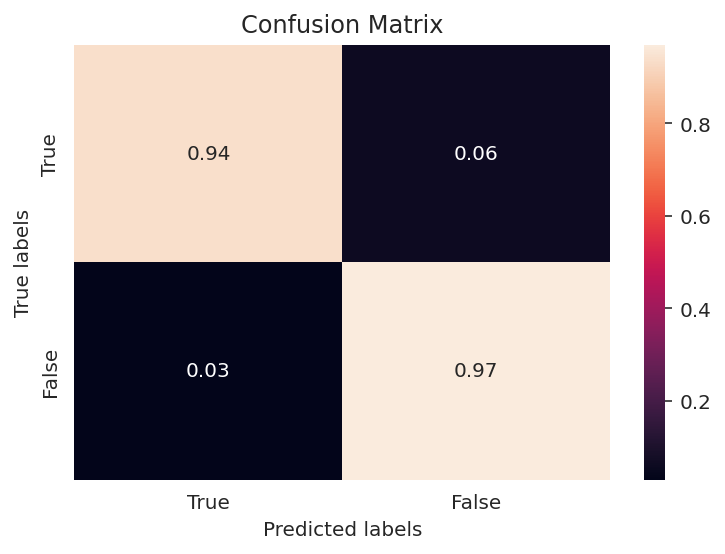

In [51]:
from evaluation import evaluate_classifier

evaluate_classifier(true_labels, preds, preds, METRICS)

## Validation metrics

In [42]:
preds = []
true_labels = []

for inputs, labels in dataloaders['validation']:
  inputs = inputs.to(device)
  labels = labels.to(device)

  batch_preds = model_trained(inputs)

  preds.append(batch_preds)
  true_labels.append(labels)

In [43]:
preds = flatten(preds)
true_labels = flatten(true_labels)

In [44]:
preds = [pr.argmax().detach().item() for pr in preds]
true_labels = [label.detach().item() for label in true_labels]

In [45]:
print('Validation data - Accuracy: {:.3f}, Balanced accuracy: {:.3f}, F1: {:.3f}, Precision: {:.3f}, Recall: {:.3f}'
              .format(accuracy_score(true_labels, preds),
                      balanced_accuracy_score(true_labels, preds),
                      f1_score(true_labels, preds),
                      precision_score(true_labels, preds),
                      recall_score(true_labels, preds)))

Validation data - Accuracy: 0.959, Balanced accuracy: 0.954, F1: 0.941, Precision: 0.943, Recall: 0.939
